In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_masks
import FILE_PATHS
import pandas as pd

from training_masks import(
    train, 
    plot_loss_curves
)

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 5
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False

filename = "../EchoNet-Dynamic/models/mask_model.pth"

In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model_type = "masks"

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_masks(
    FILE_PATHS.IMAGES,
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks
1599, 1599
VALIDATION PATHS LENGTHS: images, masks
400, 400


In [6]:
model_0_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5808 | train_acc: 0.7432 | test_loss: 0.6503 | test_acc: 0.8236


 20%|██        | 1/5 [01:25<05:43, 85.99s/it]

Epoch: 2 | train_loss: 0.3838 | train_acc: 0.9785 | test_loss: 0.3754 | test_acc: 0.9790


 40%|████      | 2/5 [02:55<04:23, 87.81s/it]

Epoch: 3 | train_loss: 0.3483 | train_acc: 0.9816 | test_loss: 0.3394 | test_acc: 0.9819


 60%|██████    | 3/5 [04:23<02:55, 87.87s/it]

Epoch: 4 | train_loss: 0.3281 | train_acc: 0.9834 | test_loss: 0.3222 | test_acc: 0.9826


 80%|████████  | 4/5 [05:49<01:27, 87.35s/it]

Epoch: 5 | train_loss: 0.3118 | train_acc: 0.9848 | test_loss: 0.3111 | test_acc: 0.9828


100%|██████████| 5/5 [07:16<00:00, 87.25s/it]


In [50]:
torch.save(model.state_dict(), filename)

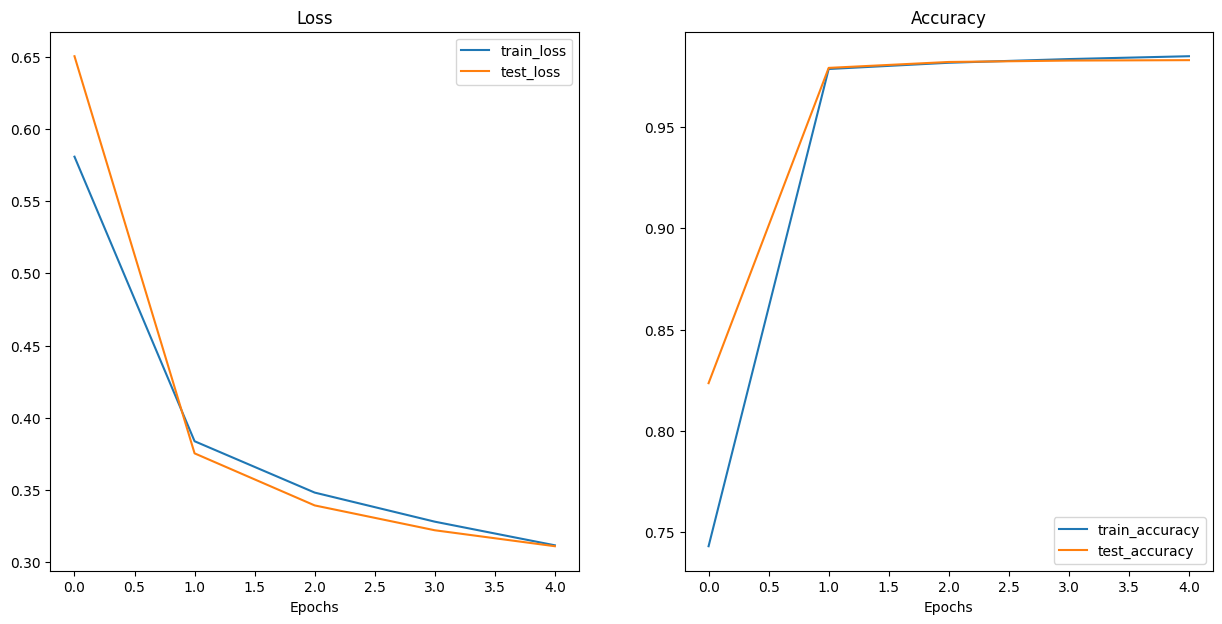

In [8]:
plot_loss_curves(model_0_results)

In [9]:
mask_model = pd.DataFrame(model_0_results)
mask_model.to_csv("mask_model.csv")
